# Compute metrics for different runs and plot them
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.3.0

## Python stuff

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from build_data import build_hurricane_data
import model_diagnostics
import prediction
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

dpiFig = 400

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "17 May 2022"

EXP_NAME_LIST = (
                 "intensity302_EPCP48",          
                 "intensity412_EPCP48",   
                 "intensity432_EPCP48",             
                 "intensity422_EPCP48",          
                 )

APPEND_NAME = ''#'_paper'

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
METRIC_PATH = "saved_metrics/"
FIGURE_PATH = "figures/paper_figures/"
PREDICTION_PATH = "saved_predictions/"

## Code for plots

In [3]:
FS = 16

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Get the dataframe

In [4]:
df_metrics = pd.DataFrame()

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)

    # set testing data
    if settings["test_condition"] == "leave-one-out":
        TESTING_YEARS_LIST = (2020,)
    elif settings["test_condition"] == "years":
        TESTING_YEARS_LIST = (np.copy(settings["years_test"]))
    else:
        raise NotImplementError('no such testing condition')
        
        
    for testing_years in TESTING_YEARS_LIST:        
        # set testing year
        settings["years_test"] = (testing_years,)
    
    
        for rng_seed in settings["rng_seed_list"]:
            settings['rng_seed'] = rng_seed
            NETWORK_SEED_LIST = [settings["rng_seed"]]
            network_seed = NETWORK_SEED_LIST[0]
    
            model_name = (
                exp_name + "_" + 
                str(testing_years) + '_' +
                settings["uncertainty_type"] + '_' + 
                f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
            )

            # load the metric filename
            metric_filename = METRIC_PATH + model_name + '_metrics.pickle'  
            if os.path.exists(metric_filename)==False:
                print(metric_filename + ' DOES NOT exist. Skipping...')
                continue

            # pprint.pprint(model_name)
            df = pd.read_pickle(metric_filename)
            try:
                df = pd.read_pickle(metric_filename)
            except:
                print(metric_filename)
                print('did not work')
            # df['basin_lead'] = exp_name[exp_name.rfind('_')+1:]

            df_metrics = pd.concat([df_metrics,df])
# get best validation results            
idx = df_metrics.groupby(['exp_name', 'testing_years'], sort=False)['median_error_reduction_val'].transform(max) == df_metrics['median_error_reduction_val']
df_metrics_bestval = df_metrics[idx]

BEST_VAL_ONLY = False
if BEST_VAL_ONLY:
    print("**plotting only the best seed for validation error reductions**")
    df_metrics = df_metrics[idx]

# df_metrics

In [5]:
df_metrics

,uncertainty_type,network_seed,rng_seed,exp_name,basin_lead,testing_years,pit_D_test,iqr_capture_test,iqr_error_spearman_test,iqr_error_pearson_test,...,iqr_error_pearson_valtest,iqr_error_spearman_p_valtest,iqr_error_pearson_p_valtest,cons_error_valtest,mean_error_valtest,median_error_valtest,mode_error_valtest,mean_error_reduction_valtest,median_error_reduction_valtest,mode_error_reduction_valtest
0,shash3,222,222,intensity302_EPCP48,EPCP48,2020,0.026306,0.540323,0.499487,0.495243,...,0.423970,3.121838e-17,1.444395e-15,11.982717,10.785949,10.751598,11.163580,1.196768,1.231119,0.819136
0,shash3,333,333,intensity302_EPCP48,EPCP48,2020,0.030645,0.548387,0.406760,0.458683,...,0.415609,3.152923e-16,5.807188e-15,13.003704,11.016883,10.805583,11.134568,1.986821,2.198121,1.869136
0,shash3,416,416,intensity302_EPCP48,EPCP48,2020,0.035557,0.572581,0.499544,0.492225,...,0.477807,1.104093e-22,6.969947e-20,13.173148,10.768983,10.773281,11.301543,2.404165,2.399867,1.871605
0,shash3,599,599,intensity302_EPCP48,EPCP48,2020,0.027514,0.556452,0.485917,0.506409,...,0.488585,6.150966e-19,7.649211e-21,12.696913,11.016608,10.869541,11.309877,1.680305,1.827372,1.387036
0,shash3,739,739,intensity302_EPCP48,EPCP48,2020,0.036460,0.564516,0.485237,0.467744,...,0.466832,1.082039e-18,6.111733e-19,12.891357,10.821497,10.692004,10.911728,2.069860,2.199353,1.979629
0,bnn,222,222,intensity412_EPCP48,EPCP48,2020,0.040355,0.620968,0.526269,0.525487,...,0.437242,3.020793e-17,1.464137e-16,11.982717,10.857994,10.819732,10.729690,1.124722,1.162985,1.253026
0,bnn,333,333,intensity412_EPCP48,EPCP48,2020,0.043007,0.604839,0.490197,0.476970,...,0.373061,4.429591e-15,3.884011e-12,13.003704,11.054671,11.044094,11.034431,1.949033,1.959610,1.969273
0,bnn,416,416,intensity412_EPCP48,EPCP48,2020,0.030002,0.604839,0.518489,0.518619,...,0.445615,7.437646e-18,3.277987e-17,13.173148,11.017193,11.038221,11.114575,2.155955,2.134927,2.058573
0,bnn,599,599,intensity412_EPCP48,EPCP48,2020,0.030857,0.604839,0.607868,0.575626,...,0.507294,1.407563e-23,1.364946e-22,12.696913,11.124480,11.088132,10.953814,1.572433,1.608781,1.743099
0,bnn,739,739,intensity412_EPCP48,EPCP48,2020,0.037515,0.596774,0.536365,0.507629,...,0.494040,1.164461e-21,2.425690e-21,12.891357,10.890740,10.886029,10.924836,2.000617,2.005328,1.966521


## Figure for main paper

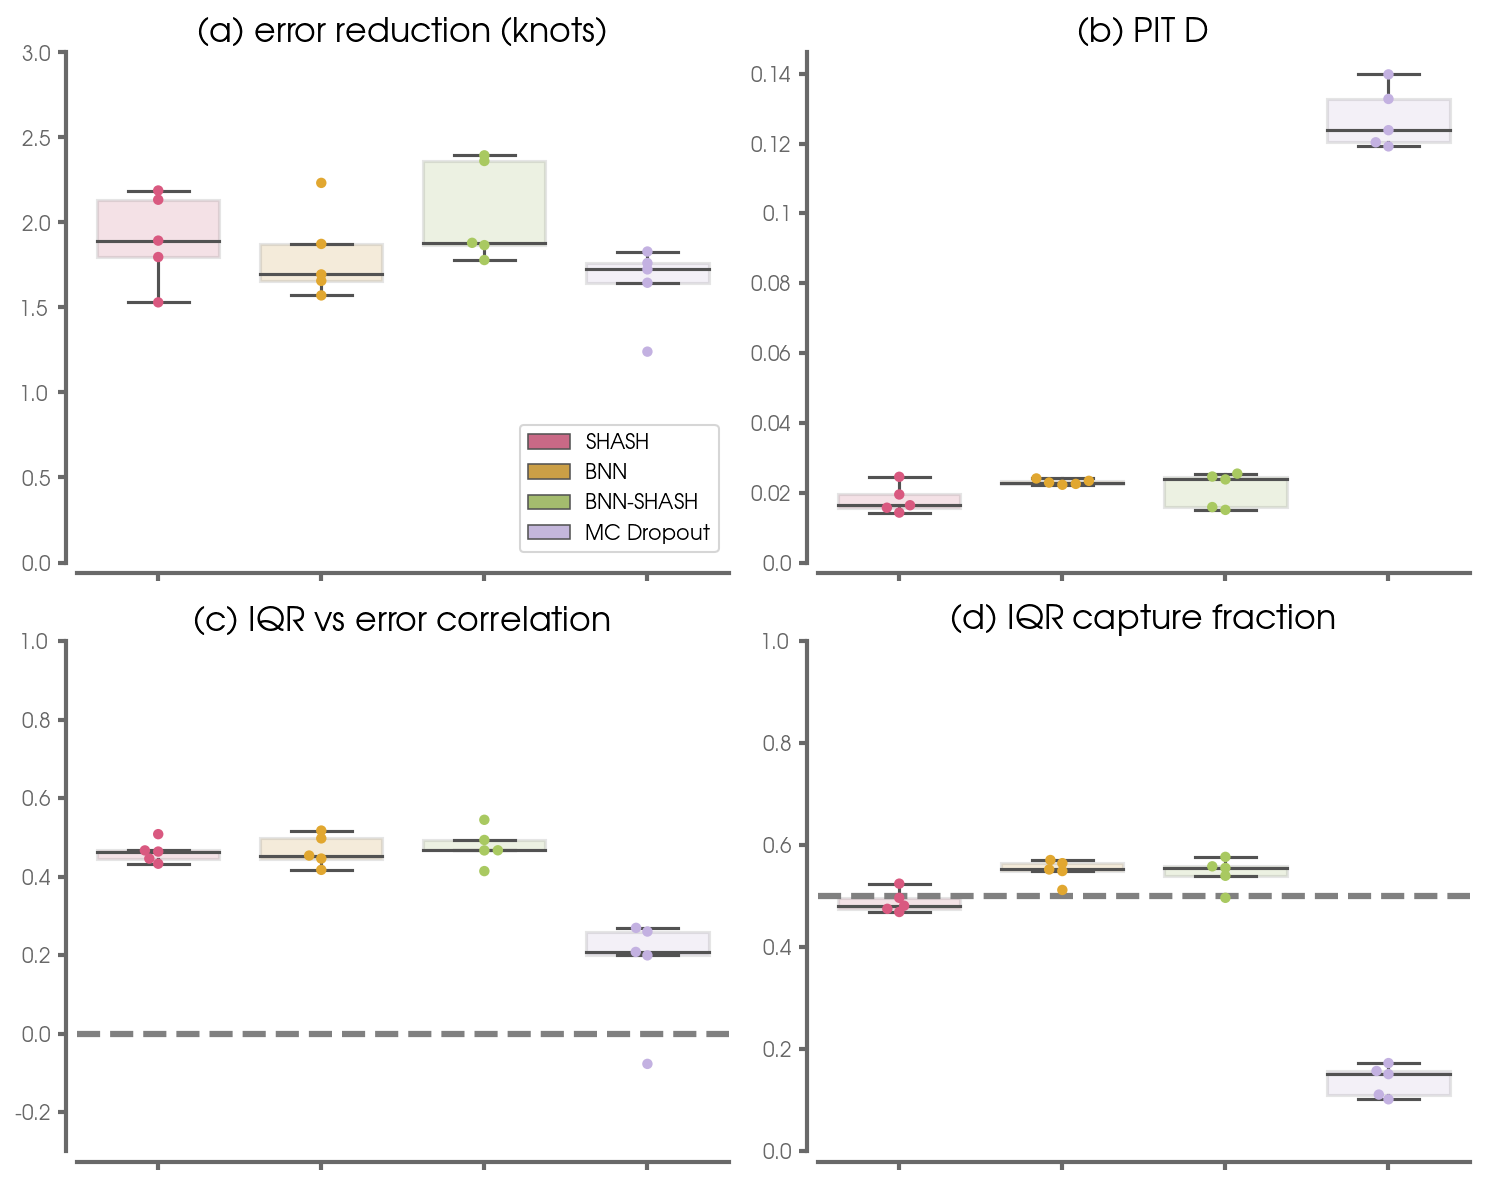

In [10]:
import seaborn as sns
colors = ('#D95980','#E1A730','#A9C961','#C3B1E1','#351F27')#('#284E60','#D95980','#C3B1E1','#FFA83A')#colors = ('#284E60','#FFA83A','#D95980','#C3B1E1',)#('#284E60','#E1A730','#D95980','#C3B1E1','#351F27','#A9C961')
panel_letters = ('(a)','(b)','(c)','(d)')
x_axis_list = ("exp_name",)#("basin_lead", "exp_name")

metric_data = ''
metric_list = ('median_error_reduction_test',
               'pit_D_valtest',
               'iqr_error_spearman_valtest',                                                                     
               'iqr_capture_valtest',
              )
title_text = ('(a) error reduction (knots)',
              '(b) PIT D',
              '(c) IQR vs error correlation',
              '(d) IQR capture fraction',
             )

for x_axis in x_axis_list:
    f, axs = plt.subplots(2, 2, figsize=(10,8))
    axs = axs.flatten()
    
    for imetric, metric in enumerate([m + metric_data for m in metric_list]):
        ax = axs[imetric]
        g1 = sns.boxplot(x=x_axis, 
                         y=metric, 
                         hue="uncertainty_type",
                         data=df_metrics,
                         palette=colors,
                         width=.75,
                         dodge=False,                    
                         boxprops={'alpha':.2,
                                   'edgecolor': 'gray',
                                  },
                         fliersize=0,
                         ax=ax)
        g2 = sns.swarmplot(x=x_axis, 
                           y=metric, 
                           hue="uncertainty_type",
                           palette=colors,
                           data=df_metrics, 
                           size=5,
                           dodge=False,
                           ax=ax)
        if imetric == 0:
            handles, labels = ax.get_legend_handles_labels()
            # ax.legend(handles[:3], ('SHASH','BNN','MC Dropout'),fontsize=12,frameon=True)
            ax.legend(handles[:4], ('SHASH','BNN','BNN-SHASH','MC Dropout'),fontsize=10,frameon=True,loc=4)                        
        else:
            ax.get_legend().remove()
        
        if(metric.find('iqr_capture') > -1):
            ax.axhline(y=0.5,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(0,1.0)
        if(metric.find('pit_D') > -1):
            ax.set_ylim(0,None)
        if(metric.find('reduction') > -1):
            # ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(0,3.)
        if(metric.find('reduction') == -1 and metric.find('n_error') > -1):
            ax.set_ylim(0.,22.)
        if(metric.find('iqr_error')> -1):
            ax.set_ylim(-.3,1.)
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')        

        ax.set_title(title_text[imetric],
                     fontsize=FS,
                     color='k',
                    )
            
        # ax.set_title(panel_letters[imetric] + ' ' + metric + APPEND_NAME,
        #              fontsize=FS,
        #              color='k',
        #             )
        
        # ax.get_legend().remove()
        x_tick_labels = ax.get_xticklabels()
        ax.set_xticklabels(x_tick_labels,rotation = 30)        
        ax.set_xticklabels([])
        yticks = np.around(ax.get_yticks(),3)
        ax.set_yticklabels(yticks)       
        ax.set_ylabel('')
        
        format_spines(ax)
        ax.set_xticklabels(x_tick_labels,rotation = 30)
        ax.set_xlabel('')
        
    plt.tight_layout()    
    plt.savefig(FIGURE_PATH + 'uq_comparisonsMetrics' + APPEND_NAME + '.png', dpi=dpiFig)    
    plt.show()

In [7]:
for exp_name in df_metrics["exp_name"].unique():
    df_show = df_metrics.loc[df_metrics["exp_name"]==exp_name][["exp_name",
                                                                "network_seed", 
                                                                "median_error_reduction_val",
                                                                "median_error_reduction_test",                                                                
                                                               ]]
    display(df_show)

,exp_name,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity302_EPCP48,222,0.880464,1.796689
0,intensity302_EPCP48,333,2.237971,2.133845
0,intensity302_EPCP48,416,2.713906,1.893354
0,intensity302_EPCP48,599,2.011609,1.530219
0,intensity302_EPCP48,739,2.206326,2.188107


,exp_name,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity412_EPCP48,222,0.720468,1.873978
0,intensity412_EPCP48,333,1.834072,2.232943
0,intensity412_EPCP48,416,2.451207,1.656678
0,intensity412_EPCP48,599,1.590953,1.571039
0,intensity412_EPCP48,739,2.203439,1.694529


,exp_name,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity432_EPCP48,222,0.884264,1.866732
0,intensity432_EPCP48,333,1.875932,2.394945
0,intensity432_EPCP48,416,2.140687,1.880313
0,intensity432_EPCP48,599,1.491098,2.361812
0,intensity432_EPCP48,739,1.616809,1.779163


,exp_name,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity422_EPCP48,222,0.901577,1.829180
0,intensity422_EPCP48,333,1.850757,1.645513
0,intensity422_EPCP48,416,1.675870,1.761316
0,intensity422_EPCP48,599,0.895817,1.240298
0,intensity422_EPCP48,739,1.661405,1.724154
